#Librerias y funciones definidas

## Librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageEnhance, ImageFilter
from skimage.io import imread, imshow, show
import scipy.fftpack as fp
from scipy import ndimage, misc, signal
from scipy.signal import convolve2d 
from skimage import data, img_as_float, img_as_ubyte, exposure, io, color
from skimage.color import rgb2gray
from skimage.exposure import cumulative_distribution
from skimage.transform import rescale
from skimage.io import imread, imshow, show, imsave

import numpy.fft

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from skimage import color, data, restoration

## Funciones de clase

In [2]:
def cdf(im):
    '''
    computes the CDF of an image im as 2D numpy ndarray
    '''
    c, b = cumulative_distribution(im)
    # pad the beginning and ending pixels and their CDF values
    c = np.insert(c, 0, [0]*b[0])
    c = np.append(c, [1]*(255-b[-1]))
    return c

def hist_matching(c, c_t, im):
       '''
       c: CDF of input image computed with the function cdf()
       c_t: CDF of template image computed with the function cdf()
       im: input image as 2D numpy ndarray
       returns the modified pixel values for the input image
       '''
       pixels = np.arange(256)
       # find closest pixel-matches corresponding to the CDF of the input image, given the value of the CDF H of
       # the template image at the corresponding pixels, s.t. c_t = H(pixels)<=> pixels = H-1(c_t)
       new_pixels = np.interp(c, c_t, pixels)
       im = (np.reshape(new_pixels[im.ravel()], im.shape)).astype(np.uint8)
       return im

## Path y funciones creadas

In [3]:
path_im = '/content/drive/MyDrive/Universidad/6Sexto/Procesamiento digital de imágenes/imagenesDIP/'
T = 'True'
def convolve_DIP(image,kernel):
    image_conv = ndimage.convolve(image,kernel,mode='nearest')
    image_conv = np.clip(image_conv,0,1)
    return image_conv

def Sharpen_kernel(size):
    sharpen_kernel = np.full((size,size),-1)
    value = size*size
    sharpen_kernel[int(size/2),int(size/2)] = value
    sharpen_kernel = np.expand_dims(sharpen_kernel,axis=2)
    return sharpen_kernel

def Blur_kernel(size):
    blur_kernel = np.full([size,size],1/(size*size))
    blur_kernel = np.expand_dims(blur_kernel,axis=2)
    return blur_kernel

def Motion_kernel(size):
    motion_kernel = np.zeros([size,size])
    for i in range(motion_kernel.shape[0]):
        for j in range(motion_kernel.shape[1]):
            if i==j:
                motion_kernel[i,j] = 1/size
    motion_kernel = np.expand_dims(motion_kernel,axis=2)
    return motion_kernel

def histogrammatchingRGB(image,image_template):
    image = img_as_ubyte(image)
    
    image_r, image_g, image_b = image[:,:,0], image[:,:,1], image[:,:,2]
    imaget_r, imaget_g, imaget_b = image_template[:,:,0], image_template[:,:,1], image_template[:,:,2]

    c_r = cdf(image_r)
    c_g = cdf(image_g)
    c_b = cdf(image_b)
    ct_r = cdf(imaget_r)
    ct_g = cdf(imaget_g)
    ct_b = cdf(imaget_b)

    p = np.arange(256)

    image_matchr = hist_matching(c_r, ct_r, image_r)
    image_matchg = hist_matching(c_g, ct_g, image_g)
    image_matchb = hist_matching(c_b, ct_b, image_b)
    c_matchr = cdf(image_matchr)
    c_matchg = cdf(image_matchg)
    c_matchb = cdf(image_matchb)

    image_final = np.zeros((image.shape[0],image.shape[1],3))
    image_final[:,:,0] =  image_matchr 
    image_final[:,:,1] =  image_matchg 
    image_final[:,:,2] =  image_matchb 
    return image_final

def verproceso(image,title1,imagep,title2):
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title(title1)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(imagep)
    plt.title(title2)
    plt.axis('off')
    plt.show()

# Carga imágen

In [4]:
im = Image.open(path_im+'Test.jpg')

# Desarrollo del proyecto

In [5]:
print('Por favor seleccione las mejoras que desee aplicar a la imagen:')
contrast_check = widgets.Text()
def check(Contrast_activation):
    contrast_check.value = str(Contrast_activation)
interact(check, Contrast_activation=False);

equalization_check = widgets.Text()
def check(Equalization_activation):
    equalization_check.value = str(Equalization_activation)
interact(check, Equalization_activation=False);

powerlaw_check = widgets.Text()
def check(Powerlaw_Activation):
    powerlaw_check.value = str(Powerlaw_Activation)
interact(check, Powerlaw_Activation=False);

Por favor seleccione las mejoras que desee aplicar a la imagen:


interactive(children=(Checkbox(value=False, description='Contrast_activation'), Output()), _dom_classes=('widg…

interactive(children=(Checkbox(value=False, description='Equalization_activation'), Output()), _dom_classes=('…

interactive(children=(Checkbox(value=False, description='Powerlaw_Activation'), Output()), _dom_classes=('widg…

In [6]:
check3 = powerlaw_check.value
if check3 == T:
    print('\nSeleccione el valor de gamma para realizar la mejora power-law:')
    powerlawvaluetxt = widgets.Text()
    def textvalue(Power_law_value):
        powerlawvaluetxt.value = Power_law_value
    interact(textvalue, Power_law_value=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']);


Seleccione el valor de gamma para realizar la mejora power-law:


interactive(children=(Dropdown(description='Power_law_value', options=('0.1', '0.2', '0.3', '0.4', '0.5', '0.6…

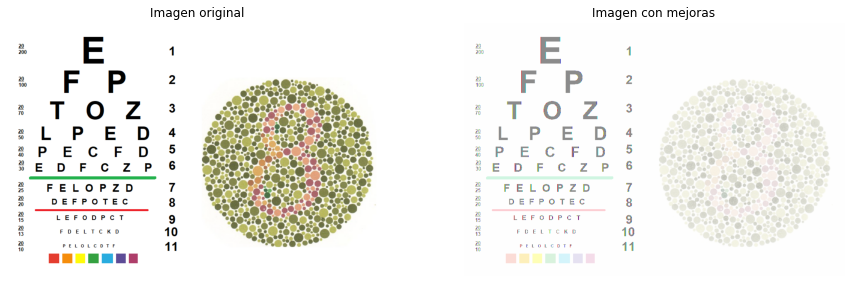

In [8]:
imm = im.convert('RGB')

#Contrast matching
check1 = contrast_check.value
if check1 == T:
    contrast = ImageEnhance.Contrast(imm)
    imm = np.reshape(np.array(contrast.enhance(2).getdata()).astype(np.uint8),(imm.height,imm.width,3))

#Histogram equalization
imm = img_as_float(imm)
check2 = equalization_check.value
if check2 == T:
    imm = exposure.equalize_adapthist(imm)

#Power-law transform como mejora
if check3 == T:
    c=1
    gamma = float(powerlawvaluetxt.value)
    imm = c*(imm**gamma)

verproceso(im,'Imagen original',imm,'Imagen con mejoras')
imm = 255*img_as_ubyte(imm)
imsave(path_im+'Test2.jpg',imm)

In [9]:
print('Por favor seleccione las transformaciones que desee aplicar a la imagen:')
logtransform_check = widgets.Text()
def check(Logtransform_activation):
    logtransform_check.value = str(Logtransform_activation)
interact(check, Logtransform_activation=False);

histogram_matching_check = widgets.Text()
def check(Histogram_matching_activation):
    histogram_matching_check.value = str(Histogram_matching_activation)
interact(check, Histogram_matching_activation=False);

not_color_check = widgets.Text()
def check(Not_color_activation):
    not_color_check.value = str(Not_color_activation)
interact(check, Not_color_activation=False);

Por favor seleccione las transformaciones que desee aplicar a la imagen:


interactive(children=(Checkbox(value=False, description='Logtransform_activation'), Output()), _dom_classes=('…

interactive(children=(Checkbox(value=False, description='Histogram_matching_activation'), Output()), _dom_clas…

interactive(children=(Checkbox(value=False, description='Not_color_activation'), Output()), _dom_classes=('wid…

In [10]:
check4 = logtransform_check.value
if check4 == T:
    print('\nAjuste el valor para aplicar en logtransform:')
    logtransformbar = widgets.Text()
    def slider(Log_transform_level):
        logtransformbar.value = str(Log_transform_level)
    interact(slider, Log_transform_level = widgets.IntSlider(min=25, max=40, step=1, value=30));

check6 = not_color_check.value
if check6 == T:
    print('Seleccione el color que desee suprimir:')
    not_colortxt = widgets.Text()
    def textvalue(Not_color):
        not_colortxt.value = str(Not_color)
    interact(textvalue, Not_color=['R','G','B']);

Seleccione el color que desee suprimir:


interactive(children=(Dropdown(description='Not_color', options=('R', 'G', 'B'), value='R'), Output()), _dom_c…

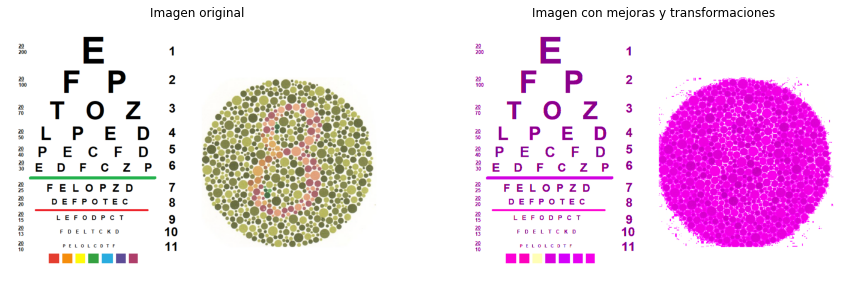

In [11]:
immt = Image.fromarray((imm * 255).astype(np.uint8))
#Log transform
if check4 == T:
    log_level = int(logtransformbar.value)
    immt = immt.point(lambda i:(log_level)*np.log(1+i))

#Histogram matching
check5 = histogram_matching_check.value
if check5 == T:
    template = img_as_ubyte(imread(path_im+'Rueda_colores.jpg'))
    immt = histogrammatchingRGB(immt,template)
    immt = Image.fromarray((immt).astype(np.uint8))

# Not color 
if check6 == T:
    colorsup = not_colortxt.value
    for x in range(immt.size[0]):
        for y in range(immt.size[1]):
            r, g, b= immt.getpixel((x,y))
            if r <= 255 and colorsup=='R' and g!=255 and b!=255:
                immt.putpixel((x,y), (0,g,b))
            else:
                if r !=255 and colorsup=='G' and g<= 255 and b!=255:
                    immt.putpixel((x,y), (r,0,b))
                else: 
                    if r !=255 and colorsup=='B' and g!=255 and b <= 255:
                        immt.putpixel((x,y), (r,g,0))
        immt = immt.convert('RGB')

verproceso(im,'Imagen original',immt,'Imagen con mejoras y transformaciones')

In [12]:
print('Por favor seleccione los filtros que desee aplicar a la imagen:')
sharpen_check = widgets.Text()
def check(Sharp_Activation):
    sharpen_check.value = str(Sharp_Activation)
interact(check, Sharp_Activation=False);

motion_check = widgets.Text()
def check(Motion_Activation):
    motion_check.value = str(Motion_Activation)
interact(check, Motion_Activation=False);

blur_check = widgets.Text()
def check(Blur_Activation):
    blur_check.value = str(Blur_Activation)
interact(check, Blur_Activation=False);

Por favor seleccione los filtros que desee aplicar a la imagen:


interactive(children=(Checkbox(value=False, description='Sharp_Activation'), Output()), _dom_classes=('widget-…

interactive(children=(Checkbox(value=False, description='Motion_Activation'), Output()), _dom_classes=('widget…

interactive(children=(Checkbox(value=False, description='Blur_Activation'), Output()), _dom_classes=('widget-i…

In [13]:
check7 = sharpen_check.value  
if check7 == T:
    print('\nAjuste el tamaño del sharpen kernel:')
    sharpenbar = widgets.Text()
    def slider(Sharpen_kernel_size):
        sharpenbar.value = str(Sharpen_kernel_size)
    interact(slider, Sharpen_kernel_size = widgets.IntSlider(min=1, max=15, step=2, value=7));

check8 = motion_check.value  
if check8 == T:
    print('\nAjuste el tamaño del motion kernel:')
    motionbar = widgets.Text()
    def slider(Motion_kernel_size):
        motionbar.value = str(Motion_kernel_size)
    interact(slider, Motion_kernel_size = widgets.IntSlider(min=1, max=15, step=2, value=7));

check9 = blur_check.value  
if check9 == T:
    print('\nAjuste el tamaño del blur kernel:')
    blurbar = widgets.Text()
    def slider(Blur_kernel_size):
        blurbar.value = str(Blur_kernel_size)
    interact(slider, Blur_kernel_size = widgets.IntSlider(min=1, max=15, step=2, value=7));


Ajuste el tamaño del blur kernel:


interactive(children=(IntSlider(value=7, description='Blur_kernel_size', max=15, min=1, step=2), Output()), _d…

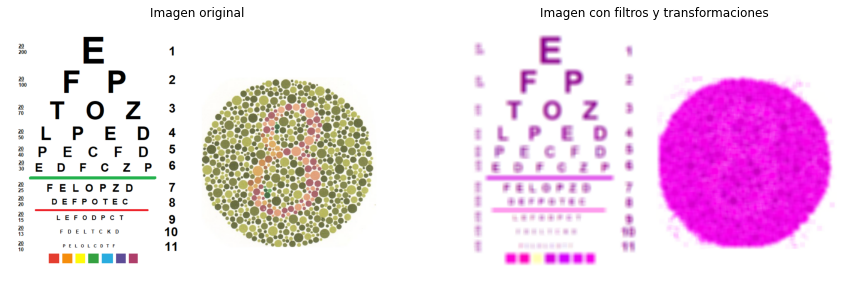

In [15]:
immtf = img_as_float(immt)

if check7 == T:
    Tam1 = int(sharpenbar.value)
    sharpen_kernel = Sharpen_kernel(Tam1)
    immtf = convolve_DIP(immtf,sharpen_kernel)

if check8 == T:
    Tam2 = int(motionbar.value)
    motion_kernel = Motion_kernel(Tam2)
    immtf = convolve_DIP(immtf,motion_kernel)

if check9 == T:    
    Tam3 = int(blurbar.value)
    blur_kernel = Blur_kernel(Tam3)
    immtf = convolve_DIP(immtf,blur_kernel)

verproceso(im,'Imagen original',immtf,'Imagen con filtros y transformaciones')